# Noctua 1 : Batch Learning

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad
from tqdm import trange

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import prk_method.prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])


## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 1

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
# validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence #[:100]
print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))



# Assuming the necessary functions like IRK4.find_error, convert.Convert_toOneD, and matrix operations are defined


# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print(A1D.shape)

# Learning rate
learning_rate = 0.0001

# Single Halton sequence element
halton_element = halton_sequence[0]

# Function to compute error
def compute_error(A1D, halton_element):
    return IRK4.find_error(A1D, halton_element)

# Gradient function
grad_fn = jax.jacfwd(compute_error)

# Central Difference method :
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        # numerical_gradients[i] = (compute_error(A1D_plus, halton_element) - compute_error(A1D_minus, halton_element)) / (2 * epsilon)
        
        numerical_gradients = numerical_gradients.at[i].set((compute_error(A1D_plus, halton_element) - compute_error(A1D_minus, halton_element)) / (2 * epsilon))

    return numerical_gradients

# Compute numerical gradients
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
numerical_gradients = numerical_gradient(A1D_initial, halton_element)

# Training loop
error_list_numerical = []
A1D_numerical = A1D_initial.copy()

for epoch in trange(100, desc="Training with Numerical gradients"):
    # Compute the gradient for the current parameters using the numerical method
    gradients = numerical_gradient(A1D_numerical, halton_element)
    
    # Update the parameters using gradient descent
    A1D_numerical = A1D_numerical - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D_numerical, halton_element)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plot the error
import matplotlib.pyplot as plt
error_list_numerical = jnp.array(error_list_numerical)
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Error", marker='o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shape of A1D
print(A1D.shape)


# Batch Learning for PC2 : noctua 1 For different settings :

In [2]:
import jax
from jax import config
config.update("jax_enable_x64", True)  #double precision

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import Test_prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE


"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""

"""
############################### Original ##########################################
Important detail noticed :

The energy error is of the range 10^-6
"""
## Lobatto 3A and B fourth order

# A1 = A2 = jnp.array([
#      [0., 0., 0., 0.],
#      [5/24, 1/3, -1/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])



""" 
Perturbed 
Important detailed noticed :
The energy error is of order : 10^-4

"""
A1 = A2 = jnp.array([
     [0., 1., 1/3, 1/2],
     [7/24, 2/3, -1/24, 0.],
     [3/6, 1/3, 1/6, 0.],
     [1., 0., 0., 0.]])
B1 = B2 = jnp.array([2/6, 1/3, 4/6, 1.])

## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 150

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]
# print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))


# Initial A1D
import optax

A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print(A1D.shape)
learning_rate = 0.0001
list_optimizers = [optax.sgd(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# # We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list
 
opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)

params = A1D

count = 0
data_epoc = 10
data_epoc_list = []
repetetion = 10
# length of halton sequence = 10 

tot_eror = 0
error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # For Energy Error 
error_list_4 = [] # For Error 

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

# Compute gradient using jacfwd
def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)

def compute_error_single(A1D, h_element):
    # print(IRK4.find_error(A1D, h_element)[0])
    return IRK4.find_error(A1D, h_element)#[0]

        
## Finding the numeric gradient. Jacfwd is not showing good results. 
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients = numerical_gradients.at[i].set(
            (compute_error_single(A1D_plus, halton_element) - compute_error_single(A1D_minus, halton_element)) / (2 * epsilon)
        )

    return numerical_gradients

# Use jax.vmap to vectorize the function over the batch
compute_grads_batched = jax.vmap(numerical_gradient, in_axes=(None, 0)) # using the numerical gradient instead of jacfwd()
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # Energy Error :
error_list_4 = [] # Error :
validation_error_list = []
tot_error = 0
tot_error_energy = 0
total_error_e = 0
validation_tot_error = 0
validation_avg_error = 0

with open('S1_output.txt', 'w') as S1_output:
    ## Batch Size
    batch_size = 100 ## just to remind you right now total halton sequence is also 100, so we are taking the whole set as the batch.
    validation_batch_size = 50
    
    for k in trange(10):
        
        tot_error = 0
        validation_tot_error = 0
        for batch_idx in range(0, len(flat_halton_sequence), batch_size):

            # Collect a batch of elements from the flattened Halton sequence
            batch_halton = flat_halton_sequence[batch_idx:batch_idx + batch_size]

            # Compute the gradients for the batch using jax.vmap
            gradF = compute_grads_batched(A1D, batch_halton)

            # Compute the average gradient for the batch
            avg_gradF = jnp.mean(gradF, axis=0)

            # Perform one step of optimization using the averaged gradient
            updates, opt_state = opt_sgd.update(avg_gradF, opt_state)

            # Apply the updates to the weights A1D for the entire batch
            A1D = optax.apply_updates(A1D, updates)

            # Calculate the total error for the batch and accumulate it
            batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
            tot_error += batch_error
        """
        # what am i tying to do here ?
        """
        avg_error = tot_error / (len(flat_halton_sequence) // batch_size) # ?
        error_list_1.append(avg_error) # ?
        
        # Write the errors to the respective files
        S1_output.write(f"{avg_error}\n")
        S1_output.flush()
    

(40,)


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


# For Noctua 1, making fori loop in the optimization file :

In [3]:
import jax
from jax import config
config.update("jax_enable_x64", True)  #double precision

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import Test_prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE


"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""

"""
############################### Original ##########################################
"""
## Lobatto 3A and B fourth order

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# """
# ############################### Perturbed ##########################################
# """
# ## Lobatto 3A and B fourth order

# A1 = A2 = jnp.array([
#      [1., 0., 3., 0.],
#      [7/24, 2/3, -5/24, 1.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([2/5, 1/3, 2/7, 1.])



## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 150

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]
# print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))


# Initial A1D
import optax

A1D = convert.Convert_toOneD(A1, A2, B1, B2)
# print(A1D.shape)
learning_rate = 0.0001
list_optimizers = [optax.sgd(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# # We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list
 
opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)

params = A1D

count = 0
data_epoc = 10
data_epoc_list = []
repetetion = 10
# length of halton sequence = 10 

tot_eror = 0
error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # For Energy Error 
error_list_4 = [] # For Error 

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

# Compute gradient using jacfwd
def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)

def compute_error_single(A1D, h_element):
    # print(type(IRK4.find_error(A1D, h_element)[0]))
    return IRK4.find_error(A1D, h_element)

        
## Finding the numeric gradient. Jacfwd is not showing good results. 
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients = numerical_gradients.at[i].set(
            (compute_error_single(A1D_plus, halton_element) - compute_error_single(A1D_minus, halton_element)) / (2 * epsilon)
        )

    return numerical_gradients

# Use jax.vmap to vectorize the function over the batch
compute_grads_batched = jax.vmap(numerical_gradient, in_axes=(None, 0)) # using the numerical gradient instead of jacfwd()
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # Energy Error :
error_list_4 = [] # Error :
validation_error_list = []
tot_error = 0
tot_error_energy = 0
total_error_e = 0
validation_tot_error = 0
validation_avg_error = 0

with open('S1_output.txt', 'w') as S1_output:
    ## Batch Size
    batch_size = 100 ## just to remind you right now total halton sequence is also 100, so we are taking the whole set as the batch.
    validation_batch_size = 50
    
    for k in trange(10):
        
        tot_error = 0
        validation_tot_error = 0
        for batch_idx in range(0, len(flat_halton_sequence), batch_size):

            # Collect a batch of elements from the flattened Halton sequence
            batch_halton = flat_halton_sequence[batch_idx:batch_idx + batch_size]

            # Compute the gradients for the batch using jax.vmap
            gradF = compute_grads_batched(A1D, batch_halton)

            # Compute the average gradient for the batch
            avg_gradF = jnp.mean(gradF, axis=0)

            # Perform one step of optimization using the averaged gradient
            updates, opt_state = opt_sgd.update(avg_gradF, opt_state)

            # Apply the updates to the weights A1D for the entire batch
            A1D = optax.apply_updates(A1D, updates)

            # Calculate the total error for the batch and accumulate it
            batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
            tot_error += batch_error
        """
        # what am i tying to do here ?
        """
        number_of_batches = len(flat_halton_sequence) * batch_size
        avg_error = tot_error / number_of_batches  # Here we are finding the average batch error:
        # Average batch error will be the addition of all the error of each batch dividing it
        # by the total number of batches. 
        # If my batch size == no of halton elements, then in that case the number of batches will be equal to 1. 
        
        error_list_1.append(avg_error) # ?
        
        # Write the errors to the respective files
        S1_output.write(f"{avg_error}\n")
        S1_output.flush()
    

100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


In [6]:
import jax
from jax import config, lax
config.update("jax_enable_x64", True)  # double precision

import jax.numpy as jnp
import numpy as np
from skopt.space import Space
from skopt.sampler import Halton
import optax

import Test_prk_for_optimization as IRK4
import Important_functions.Convert_1D2D as convert

# Initial A1D weights
A1 = A2 = jnp.array([
    [0., 0., 0., 0.],
    [5/24, 1/3, -1/24, 0.],
    [1/6, 2/3, 1/6, 0.],
    [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Generate Halton sequence
spacedim = [(-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5)]
space = Space(spacedim)
halton = Halton()
n = 150
halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
# print(A1D.shape)

learning_rate = 0.0001
opt_sgd = optax.sgd(learning_rate)
opt_state = opt_sgd.init(A1D)

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

# Define the gradient computation function
def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)

def compute_error_single(A1D, h_element):
    return IRK4.find_error(A1D, h_element)

# Finding the numeric gradient
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients = numerical_gradients.at[i].set(
            (compute_error_single(A1D_plus, halton_element) - compute_error_single(A1D_minus, halton_element)) / (2 * epsilon)
        )
    return numerical_gradients

# Vectorize the function over the batch
compute_grads_batched = jax.vmap(numerical_gradient, in_axes=(None, 0))
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

# Precompute the batch indices
num_batches = len(flat_halton_sequence) // 100

# Define the inner loop body function
def inner_loop_body(batch_idx, state):
    A1D, opt_state, tot_error = state
    # Collect a batch of elements from the flattened Halton sequence using dynamic slice
    start_idx = batch_idx * 100
    end_idx = start_idx + 100
    batch_halton = flat_halton_sequence[start_idx:end_idx]
    # Compute the gradients for the batch using jax.vmap
    gradF = compute_grads_batched(A1D, batch_halton)
    # Compute the average gradient for the batch
    avg_gradF = jnp.mean(gradF, axis=0)
    # Perform one step of optimization using the averaged gradient
    updates, opt_state = opt_sgd.update(avg_gradF, opt_state)
    # Apply the updates to the weights A1D for the entire batch
    A1D = optax.apply_updates(A1D, updates)
    # Calculate the total error for the batch and accumulate it
    batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
    tot_error += batch_error
    return A1D, opt_state, tot_error

# Define the outer loop body function using lax.scan
def outer_loop_body(i, state):
    A1D, opt_state, tot_error, b_size, l_Halton, flat_halton_sequence, batch_halton = state
    
    max_iter_inner_loop = l_Halton // b_size
    
    state_inner_loop = (A1D, opt_state, tot_error, batch_halton)
    # Run the inner loop using lax.scan
    # state, _ = jax.lax.fori_loop(0, max_iter_inner_loop, inner_loop_body, state)

    # # Extract updated values from the state
    # A1D, opt_state, tot_error = state
    # Save the latest A1D values to the weights file
    np_array_A1D = jnp.array(tot_error)
    np_array_A1D_string = str(np_array_A1D) # ' '.join(map(str, np_array_A1D))
    with open('S1_Final_weights(Perturbed_high).txt', 'w') as S1_weights:
        S1_weights.write(np_array_A1D_string)
    

    # # Calculate and save the average error
    # avg_error = tot_error / num_batches
    # with open('S1_Error(Perturbed_high).txt', 'a') as S1_output:
    #     S1_output.write(f"{avg_error}\n")

    return state  # Reset tot_error for the next outer loop iteration

# Initialize the loop variables, 
# also adding the batch size and the length of the halton sequence
len_halton = len(flat_halton_sequence)
batch_size = 100
batch_halton = flat_halton_sequence[0 : batch_size]

print(A1D)
state = (A1D, opt_state, 0.0, batch_size, len_halton, flat_halton_sequence, batch_halton)

# Perform the optimization loop using lax.fori_loop
state = jax.lax.fori_loop(0, 10, outer_loop_body, state)
A1D, opt_state, _,_,_,_,_ = state

print(A1D)

""" 
Ravi read this : Storing of each and every error wont be possible in jax loop
i will have to create a list and store all the answers there 
it will only be accessiable after the loop is completed, which wont be a good idea ,

as right now i am also check the output as the program runs 

so for now let the optimization use the normal loop and later towards the end i can
change it to jax fori loop.

"""




# # Save the latest A1D values to the weights file
# np_array_A1D = jnp.array(A1D)
# np_array_A1D_string = ' '.join(map(str, np_array_A1D))
# with open('S1_Final_weights(Perturbed_high).txt', 'w') as S1_weights:
#     S1_weights.write(np_array_A1D_string)

[ 0.          0.          0.          0.          0.20833333  0.33333333
 -0.04166667  0.          0.16666667  0.66666667  0.16666667  0.
  0.          0.          0.          0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.20833333  0.33333333 -0.04166667  0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.16666667  0.66666667  0.16666667  0.        ]
[ 0.          0.          0.          0.          0.20833333  0.33333333
 -0.04166667  0.          0.16666667  0.66666667  0.16666667  0.
  0.          0.          0.          0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.20833333  0.33333333 -0.04166667  0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.16666667  0.66666667  0.16666667  0.        ]


' \nRavi read this : Storing of each and every error wont be possible in jax loop\ni will have to create a list and store all the answers there \nit will only be accessiable after the loop is completed, which wont be a good idea ,\n\nas right now i am also check the output as the program runs \n\nso for now let the optimization use the normal loop and later towards the end i can\nchange it to jax fori loop.\n\n'

In [12]:
# Simple jax fori loop program :

def test_Fori(i, state):
    s = state
    s = s + s
    state = s
    return state

sum1 = 1
state = (sum1)
final_state = jax.lax.fori_loop(0,11, test_Fori, state)
print(final_state)

2048


In [10]:
import jax
import jax.numpy as jnp

# Initialize two JAX arrays
array1 = jnp.array([1, 2, 3, 4, 5])
array2 = jnp.zeros_like(array1)

print(array2)

def print_func(n):
    print(n, "/n")
# Define the loop body function
def loop_body(i, array2):
    print_func(array2) # this wont work
    return array2.at[i].set(array1[i])

# Perform the loop using lax.fori_loop
array2 = jax.lax.fori_loop(0, len(array1), loop_body, array2)

print(array2)


[0 0 0 0 0]
Traced<ShapedArray(int64[5])>with<DynamicJaxprTrace(level=1/0)> /n
[1 2 3 4 5]


# PC2 Noctual 1 : Energy Error, Analytical Error, and Validation set

In [6]:
import jax
from jax import config
config.update("jax_enable_x64", True)  #double precision

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap


from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import Test_prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE


"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""

# """
# ############################### Original ##########################################
# """
# ## Lobatto 3A-A fourth order

# A1 = A2 = jnp.array([
#      [0., 0., 0., 0.],
#      [5/24, 1/3, -1/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])


## Lobatto 3A 3B
A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

## Lobatto 3B
A1 = jnp.array([
     [1/6, -1/6, 0., 0.],
     [1/6, 1/3, 0., 0.],
     [1/6, 5/6, 0., 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([1/6, 2/3, 1/6, 0.])

"""
############################### Perturbed ##########################################
"""
## Lobatto 3A 

# A1 = A2 = jnp.array([
#      [1., 0., 3., 0.],
#      [7/24, 2/3, -5/24, 1.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([2/5, 1/3, 2/7, 1.])




## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 150

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]
# print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))


# Initial A1D
import optax

A1D = convert.Convert_toOneD(A1, A2, B1, B2)
# print(A1D.shape)
learning_rate = 0.0001
list_optimizers = [optax.adam(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# # We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list
 
opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)

params = A1D

count = 0
data_epoc = 10
data_epoc_list = []
repetetion = 10
# length of halton sequence = 10 

tot_eror = 0

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

# Compute gradient using jacfwd
def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)
        
## Finding the numeric gradient. Jacfwd is not showing good results. 
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients = numerical_gradients.at[i].set(
            (compute_error_single(A1D_plus, halton_element) - compute_error_single(A1D_minus, halton_element))/ (2 * epsilon)
        )

    return numerical_gradients

def compute_energy_error(A1D, h_element):
    # print(type(IRK4.find_error(A1D, h_element)[0]))
    return IRK4.find_error(A1D, h_element)[1]

def compute_error_single(A1D, h_element):
    # print(type(IRK4.find_error(A1D, h_element)[0]))
    return IRK4.find_error(A1D, h_element)[0]

# Use jax.vmap to vectorize the function over the batch
compute_grads_batched = jax.vmap(numerical_gradient, in_axes=(None, 0)) # using the numerical gradient instead of jacfwd()
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

error_list_1 = [] # Total error calculation via batch
error_list_2 = [] # Total error calculation when calculating energy error
error_list_3 = [] # Energy Error :
error_list_4 = [] # Validation Error :
validation_error_list = []
tot_error = 0
tot_error_energy = 0
total_error_e = 0
validation_tot_error = 0
validation_avg_error = 0

with open('S1_output.txt', 'w') as S1_output, open('S1_energy_error.txt', 'w') as S1_output_energy:
    ## Batch Size
    batch_size = 100 ## just to remind you right now total halton sequence is also 100, so we are taking the whole set as the batch.
    validation_batch_size = 50
    
    for k in trange(100):
        
        tot_error = 0
        tot_error_energy = 0
        total_error_e = 0
        validation_tot_error = 0
        validation_avg_error = 0
        for batch_idx in range(0, len(flat_halton_sequence), batch_size):

            # Collect a batch of elements from the flattened Halton sequence
            batch_halton = flat_halton_sequence[batch_idx:batch_idx + batch_size]

            # Compute the gradients for the batch using jax.vmap
            gradF = compute_grads_batched(A1D, batch_halton)

            # Compute the average gradient for the batch
            avg_gradF = jnp.mean(gradF, axis=0)

            # Perform one step of optimization using the averaged gradient
            updates, opt_state = opt_sgd.update(avg_gradF, opt_state)

            # Apply the updates to the weights A1D for the entire batch
            A1D = optax.apply_updates(A1D, updates)

            # Calculate the total error for the batch and accumulate it
            batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
            
            tot_error += batch_error
        """
        # what am i tying to do here ?
        """
        number_of_batches = len(flat_halton_sequence) // batch_size
        avg_error = tot_error / number_of_batches  # Here we are finding the average batch error:
        # Average batch error will be the addition of all the error of each batch dividing it
        # by the total number of batches. 
        # If my batch size == no of halton elements, then in that case the number of batches will be equal to 1. 
        
        error_list_1.append(avg_error) # ?
        
        # Write the errors to the respective files
        S1_output.write(f"{avg_error}\n")
        S1_output.flush()
        
        
        """ Energy Error and Validation set error ; 
        """
        # Recalculating both the errors : technically the above eror_list1 error should be equal to the total_error_e
        for e in range(len(halton_sequence)):
            energy_e = IRK4.find_error(A1D, halton_sequence[e])
            total_error_e += energy_e[0]
            tot_error_energy += energy_e[1]
        avg_error_e = total_error_e / len(halton_sequence)
        error_list_2.append(avg_error_e) ## Recalculating the error
        
        avg_error_energy = tot_error_energy / len(halton_sequence)
        error_list_3.append(avg_error_energy) ## Energy error Average
        
        S1_output_energy.write(f"{avg_error_energy}\n")
        S1_output_energy.flush()
        
        avg_error_e = total_error_e / len(halton_sequence)
        error_list_4.append(avg_error_e)
        """
        Validation set error calculation :
        """ 
        
        
        for v in range(0,len(validation_halton)):
            validation_tot_error += IRK4.find_error(A1D, validation_halton[v])[0]
        
        validation_avg_error = validation_tot_error / len(validation_halton)
        validation_error_list.append(validation_avg_error)
        
        
        
        """ #######################################
        """
    

100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


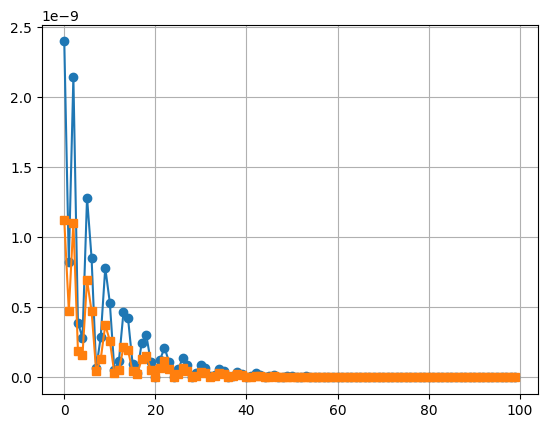

In [11]:
# Plotting :
x = range(0,100)
# plt.plot(x, error_list_1, label="Analytical Error", marker='o')
plt.plot(x, error_list_2, label="Analytical Error", marker='o')
# plt.plot(x, error_list_3, label="Energy Error", marker='o')
plt.plot(x, validation_error_list, label="Validatioin Error", marker='s')
plt.grid()
# plt.set_xlabel('Epoch')
# plt.set_ylabel('Error')
plt.show()

In [4]:
# Plotting :
x = range(0,len(1000))
plt.plot(x, error_list_1, label="Analytical Error", marker='o')
plt.plot(x, validation_error_list, label="Analytical Error", marker='o')
# plt.plot(x, error_list_3, label="Analytical Error", marker='o')
plt.grid()
# plt.set_xlabel('Epoch')
# plt.set_ylabel('Error')
plt.show()

TypeError: object of type 'int' has no len()

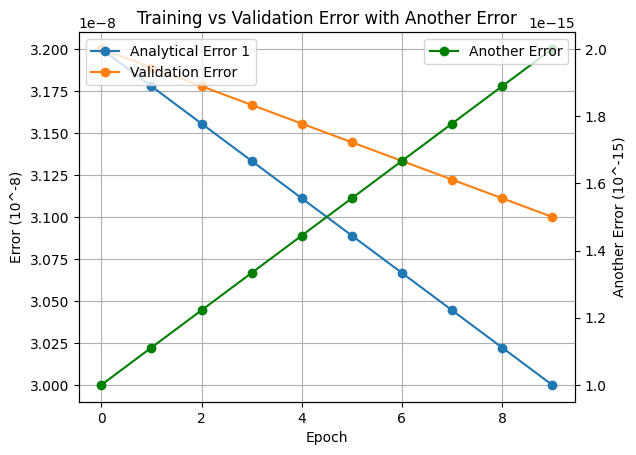

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = range(0, 10)
error_list_1 = np.linspace(3.2e-8, 3.0e-8, 10)
validation_error_list = np.linspace(3.2e-8, 3.1e-8, 10)
error_list_3 = np.linspace(1e-15, 2e-15, 10)

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first and second errors on the primary y-axis
ax1.plot(x, error_list_1, label="Analytical Error 1", marker='o')
ax1.plot(x, validation_error_list, label="Validation Error", marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Error (10^-8)')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(x, error_list_3, label="Another Error", marker='o', color='green')
ax2.set_ylabel('Another Error (10^-15)')
ax2.legend(loc='upper right')

plt.title('Training vs Validation Error with Another Error')
plt.show()

# Trying BFGS : jaxopt package

In [2]:
import jax
from jax import config
config.update("jax_enable_x64", True)  # double precision

import jax.numpy as jnp
from scipy.optimize import minimize
import numpy as np
from tqdm import trange

import Test_prk_for_optimization as IRK4
import Important_functions.Convert_1D2D as convert

# Initial matrices A1, A2, B1, B2
A1 = jnp.array([
     [1/6, -1/6, 0., 0.],
     [1/6, 1/3, 0., 0.],
     [1/6, 5/6, 0., 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([1/6, 2/3, 1/6, 0.])
A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Convert to 1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)

# Function to compute error
def compute_error(A1D, halton_sequence):
    return IRK4.find_error(A1D, halton_sequence)[0]

# Numerical gradient
def numerical_gradient(A1D, halton_sequence, epsilon=1e-5):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = jax.ops.index_update(A1D, i, A1D[i] + epsilon)
        A1D_minus = jax.ops.index_update(A1D, i, A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus, halton_sequence) - compute_error(A1D_minus, halton_sequence)) / (2 * epsilon)
    return numerical_gradients

# Wrapper function to use with scipy.optimize.minimize
def objective_function(A1D, halton_sequence):
    return compute_error(A1D, halton_sequence)

# Generate halton sequence
from skopt.space import Space
from skopt.sampler import Halton
space = Space([(-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5), (-1.0, 0.5)])
halton = Halton()
halton_sequence = halton.generate(space, 100)
halton_sequence = jnp.array(halton_sequence)

# Optimization using BFGS
result = minimize(
    fun=objective_function,
    x0=np.array(A1D),
    args=(halton_sequence,),
    method='BFGS',
    jac=lambda x: numerical_gradient(x, halton_sequence),
    options={'disp': True, 'maxiter': 1000}
)

# Save final weights
np_array_A1D = result.x
np_array_A1D_string = ' '.join(map(str, np_array_A1D))
with open('S1_Final_weights(Perturbed_high).txt', 'w') as S1_weights:
    S1_weights.write(np_array_A1D_string)

# Save the final error
final_error = result.fun
with open('S1_Error(Perturbed_high).txt', 'w') as S1_output:
    S1_output.write(f"{final_error}\n")

print("Optimization Result:", result)


TypeError: cannot reshape array of shape (4, 6) (size 24) into shape (1, 4) (size 4)

# Trying BFGS : scikit learn minimum() function

In [5]:
import jax
from jax import config
config.update("jax_enable_x64", True)  # Enable double precision

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd
from scipy.optimize import minimize
from tqdm import trange
import matplotlib.pyplot as plt

import Test_prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE

# Define the A and B matrices
A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

A1 = jnp.array([
     [1/6, -1/6, 0.5, 0.],
     [5/6, 1/3, 0., 1.],
     [1/6, 4/6, 0.3, 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([2/6, 2/3, 1/6, 0.5])

# Making the Halton code
spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5)]
space = Space(spacedim)
halton = Halton()
n = 150
halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

# Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)

# Define the objective function for optimization
def objective_function(A1D, *args):
    halton_sequence = args[0]
    total_error = 0
    for h_element in halton_sequence:
        total_error += IRK4.find_error(A1D, h_element)[0]
    return total_error / len(halton_sequence)

# Store errors
error_list_1 = []  # Total error calculation via batch
error_list_2 = []  # Total error calculation when calculating energy error
error_list_3 = []  # Energy Error :
error_list_4 = []  # Validation Error :
validation_error_list = []

with open('Testing_BFGS_Learning.txt', 'w') as S1_output :
    for epoch in trange(10):
        # Perform one iteration of BFGS
        result = minimize(objective_function, A1D, args=(halton_sequence,), method='L-BFGS-B', options={'maxiter': 1})
        
        # Update A1D with the result
        A1D = result.x
        
        # Calculate and store errors
        tot_error = 0
        tot_error_energy = 0
        total_error_e = 0
        validation_tot_error = 0
        
        for h_element in halton_sequence:
            error, energy_error = IRK4.find_error(A1D, h_element)
            tot_error += error
            tot_error_energy += energy_error
        
        avg_error = tot_error / len(halton_sequence)
        avg_error_energy = tot_error_energy / len(halton_sequence)
        
        error_list_1.append(avg_error)
        error_list_3.append(avg_error_energy)
        
        # Validation error
        for v_element in validation_halton:
            validation_tot_error += IRK4.find_error(A1D, v_element)[0]
        
        validation_avg_error = validation_tot_error / len(validation_halton)
        validation_error_list.append(validation_avg_error)


100%|██████████| 10/10 [05:56<00:00, 35.64s/it]


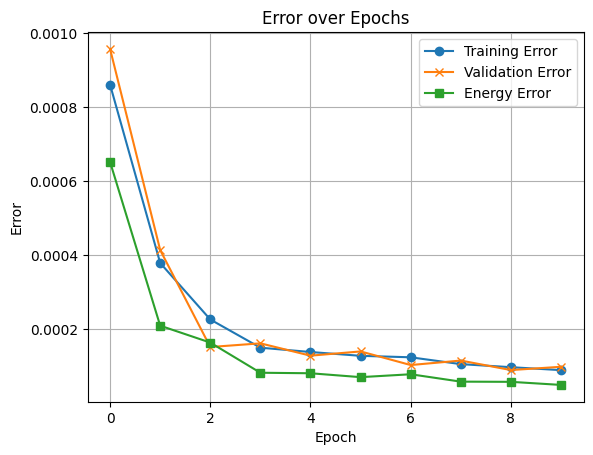

In [6]:
# Plotting the errors
plt.plot(range(len(error_list_1)), error_list_1, label="Training Error", marker='o')
plt.plot(range(len(validation_error_list)), validation_error_list, label="Validation Error", marker='x')
plt.plot(range(len(error_list_3)), error_list_3, label="Energy Error", marker='s')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error over Epochs')
plt.show()

# BFGS Setting 3 for PC2 Noctua 1 :

In [2]:
import jax
from jax import config
config.update("jax_enable_x64", True)  # Enable double precision

import numpy as np
import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd
from scipy.optimize import minimize
from tqdm import trange
import matplotlib.pyplot as plt

import Test_prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE

# Define the A and B matrices
A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

A1 = jnp.array([
     [1/6, -1/6, 0.5, 0.],
     [5/6, 1/3, 0., 1.],
     [1/6, 4/6, 0.3, 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([2/6, 2/3, 1/6, 0.5])

# Making the Halton code
spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5)]
space = Space(spacedim)
halton = Halton()
n = 150
halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

# Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)

# Define the objective function for optimization
def objective_function(A1D, *args):
    halton_sequence = args[0]
    total_error = 0
    for h_element in halton_sequence:
        total_error += IRK4.find_error(A1D, h_element)[0]
    return total_error / len(halton_sequence)

# Store errors
error_list_1 = []  # Total error calculation via batch
error_list_2 = []  # Total error calculation when calculating energy error
error_list_3 = []  # Energy Error :
error_list_4 = []  # Validation Error :
validation_error_list = []

with open('S3_Error.txt', 'w') as S3_output, open('S3_Energy_Error.txt', 'w') as S3_energy_error, open('S3_Validation.txt', 'w') as S3_validation, open('S3_Final_weights.txt', 'w') as S3_weights :
    for epoch in trange(10):
        # Perform one iteration of BFGS
        result = minimize(objective_function, A1D, args=(halton_sequence,), method='L-BFGS-B', options={'maxiter': 1})
        
        # Updating A1D with the result
        A1D = result.x
        
        # Calculating and storing errors
        tot_error = 0
        tot_error_energy = 0
        total_error_e = 0
        validation_tot_error = 0
        
        for h_element in halton_sequence:
            error, energy_error = IRK4.find_error(A1D, h_element)
            tot_error += error
            tot_error_energy += energy_error
        
        avg_error = tot_error / len(halton_sequence)
        avg_error_energy = tot_error_energy / len(halton_sequence)
        
        # error_list_1.append(avg_error)
        # error_list_3.append(avg_error_energy)
        
        # Validation error
        for v_element in validation_halton:
            validation_tot_error += IRK4.find_error(A1D, v_element)[0]
        
        validation_avg_error = validation_tot_error / len(validation_halton)
        # validation_error_list.append(validation_avg_error)

        np_array_A1D = np.array(A1D)
        np_array_A1D_string = ' '.join(map(str, np_array_A1D))
        S3_weights.seek(0)  # Move to the beginning of the file
        S3_weights.write(np_array_A1D_string) #+ '\n')
        
        S3_output.write(f"{avg_error}\n")
        S3_output.flush()
        S3_energy_error.write(f"{avg_error_energy}\n")
        S3_energy_error.flush()
        S3_validation.write(f"{validation_avg_error}\n")
        S3_validation.flush()
        
        """ 
        S3_output : is for the analitical error 
        S3_energy_error : for the energy error
        S3_validation : the validation set error
        S3_weights : the updated weights of A1D
        """


  0%|          | 0/10 [00:00<?, ?it/s]